<a href="https://colab.research.google.com/github/vishalgardas/Practice/blob/master/Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tweepy as tw #for scrapping data from witter using API
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections
import networkx as nx #for networking diagrams

from textblob import TextBlob #for polarity and subjectivity classification
import re
from wordcloud import WordCloud #for building wordcloud

import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer
stemmer=PorterStemmer()
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.util import ngrams
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, auc, confusion_matrix

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
search_term = "lockdown"
date_since = "2020-11-12"
date_upto = "2020-11-13"

# 4. Text Preprocessing

In [ ]:
data = pd.read_csv("data.csv")
df = data[['tweet']]

In [ ]:
#preprocessing of text
def preprocess_text(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)# Remove words with non-ASCII characters
    tweet = re.sub(r'@[A-Z0-9a-z_:]+','',tweet)#replace username-tags
    tweet = re.sub('#', '', tweet)
    tweet = re.sub(r'[^\w\s]', '',tweet)
    tweet = re.sub(r'[0-9]+', '', tweet)
    #tweet = re.sub('.', '', tweet)
    tweet = re.sub('rt', ' ', tweet)
    tweet = re.sub(r'^[RT]+','',tweet)#replace RT-tags
    tweet = re.sub('https?://[A-Za-z0-9./]+','',tweet)#replace URLs
    tweet = tweet.split()
    tweet = [stemmer.stem(word) for word in tweet if word not in set(stopwords.words('english'))] # Remove stop words
    tweet = " ".join(tweet)
    return tweet

In [ ]:
df['text_clean'] = df.tweet.apply(preprocess_text)
df.head(3)

<ipython-input-95-60c3c39b9912>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_clean'] = df.tweet.apply(preprocess_text)


,tweet,text_clean
0,@dbseymour Jacinda is slowly transitioning us ...,jacinda slowli transit us capit social everi l...
1,Singapore Circuit Breaker – Using qmdj to For...,singapor circuit breaker use qmdj forecast out...
2,RT @YuriLowenthal: Suicide figures are up 200%...,suicid figur sinc lockdown could friend pleas ...


## 4.1 Polarity and Subjectivity

In [ ]:
def getPolarity(text):
   return  TextBlob(text).sentiment.polarity

def getanalysis(score):
    if score < 0:
      return '-1'
    elif score == 0:
      return '0'
    else:
      return '1'

df['polarity'] = df['text_clean'].apply(getPolarity)

df['label'] = df['polarity'].apply(getanalysis)

<ipython-input-97-8856c7d808e7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['polarity'] = df['text_clean'].apply(getPolarity)
<ipython-input-97-8856c7d808e7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['polarity'].apply(getanalysis)


In [ ]:
#df['text'] = [word for word in df['text_clean'] if word not in set(stopwords.words('english'))] # Remove stop words

<ipython-input-88-bde5e776291d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = [word for word in df['text_clean'] if word not in set(stopwords.words('english'))] # Remove stop words


In [ ]:
def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity


def spellcheck(text):
    return TextBlob(text).correct()

# Create two new columns 'Subjectivity' & 'Polarity'
df['subjectivity'] = df['text_clean'].apply(getSubjectivity)

#df['text'] = df['text'].apply(spellcheck)

df['text_token'] = df['text_clean'].apply(lambda x: word_tokenize(x))

stemming = PorterStemmer()
df['text_stemmed'] = df['text_token'].apply(lambda x: " ".join([stemming.stem(i) for i in x]))

lemmatizing = WordNetLemmatizer()
df['text_lemmatized'] = df['text_token'].apply(lambda x: " ".join([lemmatizing.lemmatize(i) for i in x]))
# Show the new dataframe with columns 'Subjectivity' & 'Polarity'
df.head(3)

<ipython-input-98-d150fdfb9153>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['subjectivity'] = df['text_clean'].apply(getSubjectivity)
<ipython-input-98-d150fdfb9153>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_token'] = df['text_clean'].apply(lambda x: word_tokenize(x))
<ipython-input-98-d150fdfb9153>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

,tweet,text_clean,polarity,label,subjectivity,text_token,text_stemmed,text_lemmatized
0,@dbseymour Jacinda is slowly transitioning us ...,jacinda slowli transit us capit social everi l...,0.033333,1,0.066667,"[jacinda, slowli, transit, us, capit, social, ...",jacinda slowli transit us capit social everi l...,jacinda slowli transit u capit social everi lo...
1,Singapore Circuit Breaker – Using qmdj to For...,singapor circuit breaker use qmdj forecast out...,0.000000,0,0.000000,"[singapor, circuit, breaker, use, qmdj, foreca...",singapor circuit breaker use qmdj forecast out...,singapor circuit breaker use qmdj forecast out...
2,RT @YuriLowenthal: Suicide figures are up 200%...,suicid figur sinc lockdown could friend pleas ...,0.000000,0,0.000000,"[suicid, figur, sinc, lockdown, could, friend,...",suicid figur sinc lockdown could friend plea c...,suicid figur sinc lockdown could friend plea c...


# 5. EDA

In [ ]:
df[['tweet','text_clean','text_stemmed', 'text_lemmatized' ,'polarity', 'label']].head()

,tweet,text_clean,text_stemmed,text_lemmatized,polarity,label
0,@dbseymour Jacinda is slowly transitioning us ...,jacinda slowli transit us capit social everi l...,jacinda slowli transit us capit social everi l...,jacinda slowli transit u capit social everi lo...,0.033333,1
1,Singapore Circuit Breaker – Using qmdj to For...,singapor circuit breaker use qmdj forecast out...,singapor circuit breaker use qmdj forecast out...,singapor circuit breaker use qmdj forecast out...,0.000000,0
2,RT @YuriLowenthal: Suicide figures are up 200%...,suicid figur sinc lockdown could friend pleas ...,suicid figur sinc lockdown could friend plea c...,suicid figur sinc lockdown could friend plea c...,0.000000,0
3,RT @YuriLowenthal: Suicide figures are up 200%...,suicid figur sinc lockdown could friend pleas ...,suicid figur sinc lockdown could friend plea c...,suicid figur sinc lockdown could friend plea c...,0.000000,0
4,@Brent_Thoma @CitizenHalton @PremierScottMoe I...,make choic melbourn back jul httpstconezngpcf,make choic melbourn back jul httpstconezngpcf,make choic melbourn back jul httpstconezngpcf,0.000000,0


In [ ]:
words = df['text_token']
words[0]

['jacinda',
 'slowli',
 'transit',
 'us',
 'capit',
 'social',
 'everi',
 'lockdown',
 'becom',
 'mor',
 'httpstcoavioiazxij']

## 5.1 Most Common Words

In [ ]:
#all words in all tweets
all_words = list(itertools.chain(*words))

count_words = collections.Counter(all_words)

count_words.most_common(15)

[('lockdown', 26018),
 ('suicid', 10638),
 ('could', 10498),
 ('sinc', 10497),
 ('figur', 9521),
 ('pleas', 9506),
 ('tweet', 9202),
 ('copi', 9135),
 ('repost', 9064),
 ('tri', 8729),
 ('friend', 8126),
 ('covid', 3730),
 ('dem', 3137),
 ('demonstr', 2259),
 ('peopl', 2017)]

In [ ]:
df_count_words = pd.DataFrame(count_words.most_common(15), columns=['word', 'count'])
df_count_words

,word,count
0,lockdown,26018
1,suicid,10638
2,could,10498
3,sinc,10497
4,figur,9521
5,pleas,9506
6,tweet,9202
7,copi,9135
8,repost,9064
9,tri,8729


### 5.1.1 Histogram of most common words

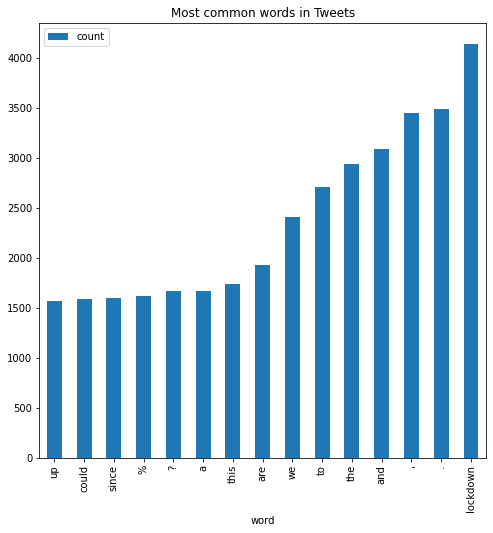

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
df_count_words.sort_values(by='count').plot.bar(x='word', y='count',
                                               ax=ax)
ax.set_title("Most common words in Tweets")
plt.show()

## 5.2 Bi-grams

In [ ]:
for text in all_words:
    token = nltk.word_tokenize(text)
    bigram = list(ngrams(token, 2))

### 5.2.1 Most common Bi-grams

In [ ]:
six = ngrams(all_words, 2)
six_count = collections.Counter(six)
df_bigram = pd.DataFrame(six_count.most_common(20), columns=['bigram', 'count'])
df_bigram

,bigram,count
0,"(lockdown, .)",11119
1,"(200, %)",10139
2,"(since, lockdown)",10033
3,"(up, 200)",9974
4,"(%, since)",9966
5,"(could, 2)",9738
6,"(suicide, figures)",9348
7,"(are, up)",9296
8,"(figures, are)",9293
9,"(., could)",9113


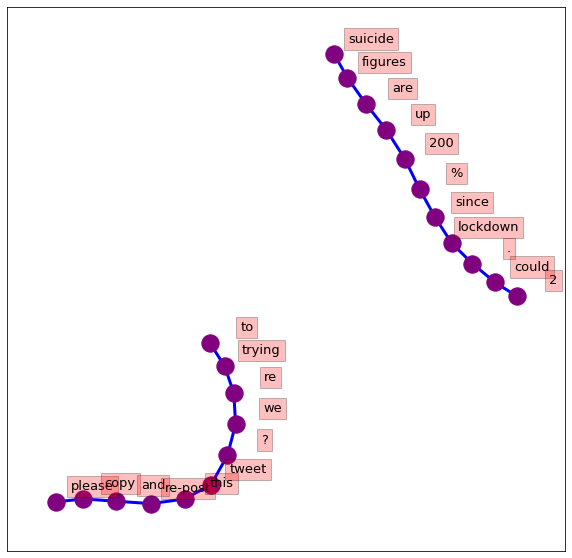

In [ ]:
d = df_bigram.set_index('bigram').T.to_dict('records')

G = nx.Graph()

for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v*10))
G.add_node("lockdown", weight=100)

fig, ax = plt.subplots(figsize=(10,10))
pos = nx.spring_layout(G, k=2)
nx.draw_networkx(G, pos, font_size=15, width=3, edge_color='blue',
                node_color='purple', with_labels=False, ax=ax)

for key, value in pos.items():
    x,y = value[0]+0.135, value[1]+0.045
    ax.text(x,y, s=key, bbox=dict(facecolor='red', alpha=0.25),
           horizontalalignment='center', fontsize=13)

### 5.2.2 Network of Bi-grams

In [ ]:
six = ngrams(all_words, 3)
six_count = collections.Counter(six)
df_trigram = pd.DataFrame(six_count.most_common(20), columns=['trigram', 'count'])
df_trigram

,trigram,count
0,"(up, 200, %)",9967
1,"(200, %, since)",9964
2,"(%, since, lockdown)",9904
3,"(since, lockdown, .)",9841
4,"(suicide, figures, are)",9280
5,"(figures, are, up)",9275
6,"(are, up, 200)",9244
7,"(lockdown, ., could)",9095
8,"(., could, 2)",9048
9,"(please, copy, and)",9039


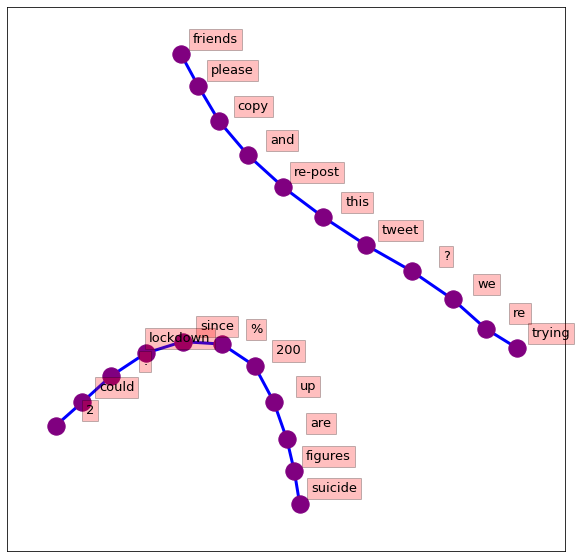

In [ ]:
d = df_trigram.set_index('trigram').T.to_dict('records')

G = nx.Graph()

for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v*10))
G.add_node("lockdown", weight=100)

fig, ax = plt.subplots(figsize=(10,10))
pos = nx.spring_layout(G, k=2)
nx.draw_networkx(G, pos, font_size=15, width=3, edge_color='blue',
                node_color='purple', with_labels=False, ax=ax)

for key, value in pos.items():
    x,y = value[0]+0.135, value[1]+0.045
    ax.text(x,y, s=key, bbox=dict(facecolor='red', alpha=0.25),
           horizontalalignment='center', fontsize=13)

## 5.3 Polarity Histogram

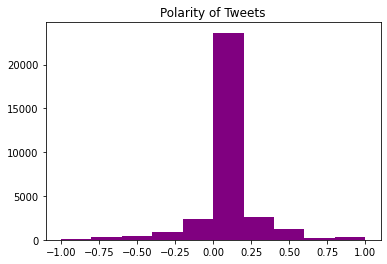

In [ ]:
df['polarity'].hist(color='purple')
plt.grid(False)
plt.title("Polarity of Tweets")
plt.show()

### 5.3.1 Polarity(labels) Histogram

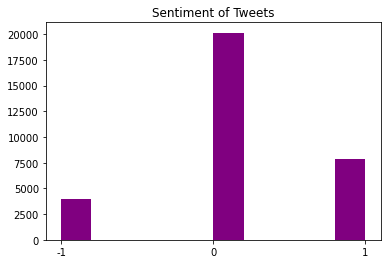

In [ ]:
df['label'].hist(color='purple')
plt.grid(False)
plt.title("Sentiment of Tweets")
plt.show()

## 5.4 Subjectivity Histogram

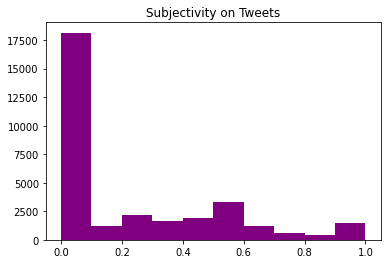

In [ ]:
df['subjectivity'].hist(color='purple')
plt.grid(False)
plt.title("Subjectivity on Tweets")
plt.show()

In [ ]:
df['label'].value_counts()

0     20151
1      7841
-1     4008
Name: label, dtype: int64

## 5.5 Scatter Plot - Polarity vs Subjectivity

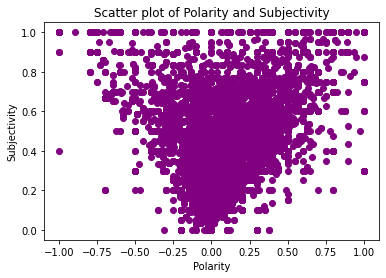

In [ ]:
plt.scatter(df['polarity'], df['subjectivity'], color='purple')
plt.xlabel("Polarity")
plt.ylabel("Subjectivity")
plt.title("Scatter plot of Polarity and Subjectivity")
plt.show()

## 5.6 Wordcloud

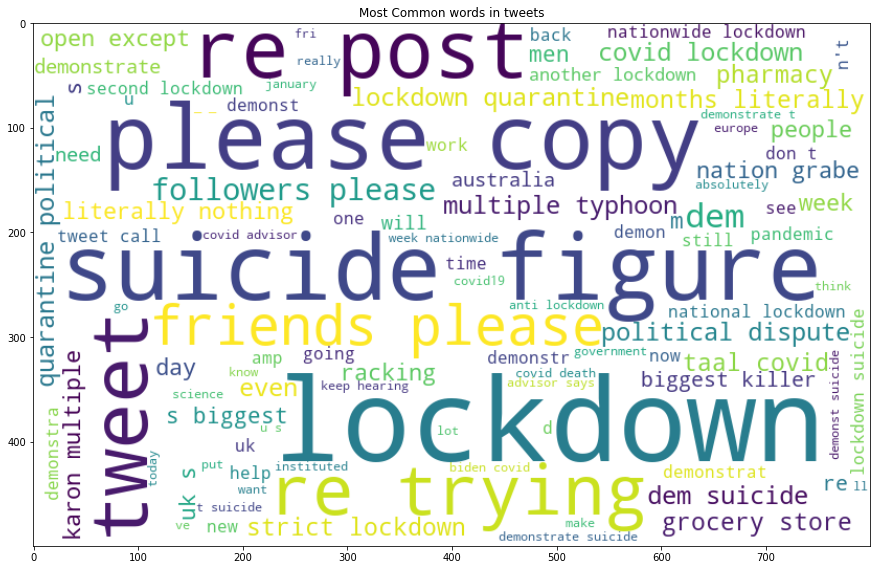

In [ ]:
words = ' '.join([text for text in all_words])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, 
                      background_color='white',max_words=100, repeat=False).generate(words)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Most Common words in tweets")
plt.show()

# 6. Models 

## 6.1 Train & Test Data

In [ ]:
x = df.text
y = df.label
xs = df.text_stemmed
xl = df.text_lemmatized

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state=42)
xs_train, xs_test, ys_train, ys_test = train_test_split(xs,y, test_size = 0.3, random_state=42)
xl_train, xl_test, yl_train, yl_test = train_test_split(xl,y, test_size = 0.3, random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [ ]:
from sklearn.model_selection import cross_val_score
cv_score = cross_val_score(lr, x, y, cv=10)
cv_score*100, cv_score.mean()*100

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1508, in fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.8/dist-packages/sklearn/base.py", line 581, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.8/dist-packages/skl

(array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]), nan)

## 6.2 Multinominal Navie Bayes

In [ ]:
y1 = y_test.copy()

In [ ]:
y_test.value_counts()

0     6022
1     2395
-1    1183
Name: label, dtype: int64

In [ ]:
#Navie Bayes MutltinomialNB
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB())])
nb.fit(x_train, y_train)

label=['negative', 'neutral','positive']
y_pred = nb.predict(x_test)
acc_nb = accuracy_score(y_pred, y_test)*100
print("accuracy =", acc_nb)
cm_nb = confusion_matrix(y_test, y_pred)
print("Confusion matrix \n", cm_nb)
clfr = metrics.classification_report(y_test, y_pred, target_names=label)
print("Classification Report: \n", clfr) 

accuracy = 82.72916666666667
Confusion matrix 
 [[ 628   35  520]
 [  41 4976 1005]
 [  13   44 2338]]
Classification Report: 
               precision    recall  f1-score   support

    negative       0.92      0.53      0.67      1183
     neutral       0.98      0.83      0.90      6022
    positive       0.61      0.98      0.75      2395

    accuracy                           0.83      9600
   macro avg       0.84      0.78      0.77      9600
weighted avg       0.88      0.83      0.83      9600



In [ ]:
nb.fit(xs_train, ys_train)
label=['negative', 'neutral','positive']
ys_pred = nb.predict(xs_test)
acc_nbs = accuracy_score(ys_pred, ys_test)*100
print("accuracy =", acc_nbs)
cm_nbs = confusion_matrix(ys_test, ys_pred)
print("Confusion matrix \n", cm_nbs)
clfr = metrics.classification_report(ys_test, ys_pred, target_names=label)
print("Classification Report: \n", clfr) 

accuracy = 80.89583333333333
Confusion matrix 
 [[ 608   46  529]
 [  80 4815 1127]
 [  13   39 2343]]
Classification Report: 
               precision    recall  f1-score   support

    negative       0.87      0.51      0.65      1183
     neutral       0.98      0.80      0.88      6022
    positive       0.59      0.98      0.73      2395

    accuracy                           0.81      9600
   macro avg       0.81      0.76      0.75      9600
weighted avg       0.87      0.81      0.82      9600



In [ ]:
nb.fit(xl_train, y_train)

label=['negative', 'neutral','positive']
y_pred = nb.predict(xl_test)
acc_nbl = accuracy_score(y_pred, y_test)*100
print("accuracy =", acc_nbl)
cm_nbl = confusion_matrix(y_test, y_pred)
print("Confusion matrix \n", cm_nbl)
clfr = metrics.classification_report(y_test, y_pred, target_names=label)
print("Classification Report: \n", clfr) 

accuracy = 82.0625
Confusion matrix 
 [[ 616   36  531]
 [  58 4927 1037]
 [  11   49 2335]]
Classification Report: 
               precision    recall  f1-score   support

    negative       0.90      0.52      0.66      1183
     neutral       0.98      0.82      0.89      6022
    positive       0.60      0.97      0.74      2395

    accuracy                           0.82      9600
   macro avg       0.83      0.77      0.76      9600
weighted avg       0.88      0.82      0.83      9600



## 6.3 Logistic Regression

In [ ]:
#Logistic regression
lr = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression())])
lr.fit(x_train, y_train)

label=['negative', 'neutral','positive']
y_pred = lr.predict(x_test)
acc_lr = accuracy_score(y_pred, y_test)*100
print("accuracy =", acc_lr)
cm_lr = confusion_matrix(y_test, y_pred)
print("Confusion matrix \n", cm_lr)
clfr = metrics.classification_report(y_test, y_pred, target_names=label)
print("Classification Report: \n", clfr) 

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy = 92.77083333333334
Confusion matrix 
 [[ 858  193  132]
 [  23 5899  100]
 [  55  191 2149]]
Classification Report: 
               precision    recall  f1-score   support

    negative       0.92      0.73      0.81      1183
     neutral       0.94      0.98      0.96      6022
    positive       0.90      0.90      0.90      2395

    accuracy                           0.93      9600
   macro avg       0.92      0.87      0.89      9600
weighted avg       0.93      0.93      0.93      9600



In [ ]:
lr.fit(xs_train, y_train)
label=['negative', 'neutral','positive']
y_pred = lr.predict(xs_test)
acc_lrs = accuracy_score(y_pred, y_test)*100
print("accuracy =", acc_lrs)
cm_lrs = confusion_matrix(y_test, y_pred)
print("Confusion matrix \n", cm_lrs)
clfr = metrics.classification_report(y_test, y_pred, target_names=label)
print("Classification Report: \n", clfr) 

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy = 91.88541666666666
Confusion matrix 
 [[ 844  195  144]
 [  39 5855  128]
 [  55  218 2122]]
Classification Report: 
               precision    recall  f1-score   support

    negative       0.90      0.71      0.80      1183
     neutral       0.93      0.97      0.95      6022
    positive       0.89      0.89      0.89      2395

    accuracy                           0.92      9600
   macro avg       0.91      0.86      0.88      9600
weighted avg       0.92      0.92      0.92      9600



In [ ]:
lr.fit(xl_train, y_train)
label=['negative', 'neutral','positive']
y_pred = lr.predict(xl_test)
acc_lrl = accuracy_score(y_pred, y_test)*100
print("accuracy =", acc_lrl)
cm_lrl = confusion_matrix(y_test, y_pred)
print("Confusion matrix \n", cm_lrl)
clfr = metrics.classification_report(y_test, y_pred, target_names=label)
print("Classification Report: \n", clfr) 

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy = 92.41666666666667
Confusion matrix 
 [[ 849  190  144]
 [  26 5879  117]
 [  53  198 2144]]
Classification Report: 
               precision    recall  f1-score   support

    negative       0.91      0.72      0.80      1183
     neutral       0.94      0.98      0.96      6022
    positive       0.89      0.90      0.89      2395

    accuracy                           0.92      9600
   macro avg       0.91      0.86      0.88      9600
weighted avg       0.92      0.92      0.92      9600



## 6.4 Linear SVM (SGD)

accuracy = 93.29166666666666
Confusion matrix 
 [[ 878  189  116]
 [  12 5926   84]
 [  43  200 2152]]
Classification Report: SGD Classifier with text 
               precision    recall  f1-score   support

    negative       0.94      0.74      0.83      1183
     neutral       0.94      0.98      0.96      6022
    positive       0.91      0.90      0.91      2395

    accuracy                           0.93      9600
   macro avg       0.93      0.87      0.90      9600
weighted avg       0.93      0.93      0.93      9600



Text(33.0, 0.5, 'True')

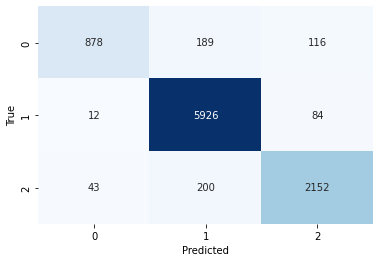

In [ ]:
#Linear Support Vector Machines
sgd = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', SGDClassifier())])
sgd.fit(x_train, y_train)

label=['negative', 'neutral','positive']
y_pred = sgd.predict(x_test)
acc_sgd = accuracy_score(y_pred, y_test)*100
print("accuracy =", acc_sgd)
cm_sgd = confusion_matrix(y_test, y_pred)
print("Confusion matrix \n", cm_sgd)
label=['negative', 'neutral','positive']
clfr = metrics.classification_report(y_test, y_pred, target_names=label)
print("Classification Report: SGD Classifier with text \n", clfr) 
sns.heatmap(cm_sgd, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
sgd.fit(xs_train, y_train)
label=['negative', 'neutral','positive']
y_pred = sgd.predict(xs_test)
acc_sgds = accuracy_score(y_pred, y_test)*100
print("accuracy =", acc_sgds)
cm_sgds = confusion_matrix(y_test, y_pred)
print("Confusion matrix \n", cm_sgds)
clfr = metrics.classification_report(y_test, y_pred, target_names=label)
print("Classification Report: \n", clfr) 

accuracy = 92.39583333333333
Confusion matrix 
 [[ 850  187  146]
 [  24 5892  106]
 [  46  221 2128]]
Classification Report: 
               precision    recall  f1-score   support

    negative       0.92      0.72      0.81      1183
     neutral       0.94      0.98      0.96      6022
    positive       0.89      0.89      0.89      2395

    accuracy                           0.92      9600
   macro avg       0.92      0.86      0.89      9600
weighted avg       0.92      0.92      0.92      9600



accuracy = 92.84375
Classification Report: SGD Classifier with text_lemmatized 
               precision    recall  f1-score   support

    negative       0.94      0.73      0.82      1183
     neutral       0.94      0.98      0.96      6022
    positive       0.90      0.89      0.90      2395

    accuracy                           0.93      9600
   macro avg       0.93      0.87      0.89      9600
weighted avg       0.93      0.93      0.93      9600



Text(33.0, 0.5, 'True')

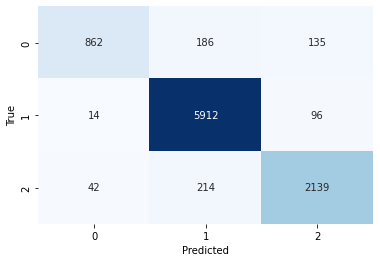

In [ ]:
sgd.fit(xl_train, y_train)
label=['negative', 'neutral','positive']
y_pred = sgd.predict(xl_test)
acc_sgdl = accuracy_score(y_pred, y_test)*100
print("accuracy =", acc_sgdl)
cm_sgdl = confusion_matrix(y_test, y_pred)
 

label=['negative', 'neutral','positive']
clfr = metrics.classification_report(y_test, y_pred, target_names=label)
print("Classification Report: SGD Classifier with text_lemmatized \n", clfr) 
sns.heatmap(cm_sgdl, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')

## 6.5 Random Forest

In [ ]:
#Random Forest
rfc = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', RandomForestClassifier())])
rfc.fit(x_train, y_train)

label=['negative', 'neutral','positive']
y_pred = rfc.predict(x_test)
acc_rfc = accuracy_score(y_pred, y_test)*100
print("accuracy =", acc_rfc)
cm_rfc = confusion_matrix(y_test, y_pred)
print("Confusion matrix \n", cm_rfc)
clfr = metrics.classification_report(y_test, y_pred, target_names=label)
print("Classification Report: \n", clfr) 

accuracy = 92.33333333333333
Confusion matrix 
 [[ 817  252  114]
 [   1 5967   54]
 [  26  289 2080]]
Classification Report: 
               precision    recall  f1-score   support

    negative       0.97      0.69      0.81      1183
     neutral       0.92      0.99      0.95      6022
    positive       0.93      0.87      0.90      2395

    accuracy                           0.92      9600
   macro avg       0.94      0.85      0.88      9600
weighted avg       0.93      0.92      0.92      9600



In [ ]:
rfc.fit(xs_train, y_train)
label=['negative', 'neutral','positive']
y_pred = rfc.predict(xs_test)
acc_rfcs = accuracy_score(y_pred, y_test)*100
print("accuracy =", acc_rfcs)
cm_rfcs = confusion_matrix(y_test, y_pred)
print("Confusion matrix \n", cm_rfcs)
clfr = metrics.classification_report(y_test, y_pred, target_names=label)
print("Classification Report: \n", clfr) 

accuracy = 91.88541666666666
Confusion matrix 
 [[ 802  253  128]
 [   4 5936   82]
 [  24  288 2083]]
Classification Report: 
               precision    recall  f1-score   support

    negative       0.97      0.68      0.80      1183
     neutral       0.92      0.99      0.95      6022
    positive       0.91      0.87      0.89      2395

    accuracy                           0.92      9600
   macro avg       0.93      0.84      0.88      9600
weighted avg       0.92      0.92      0.92      9600



In [ ]:
rfc.fit(xl_train, y_train)
label=['negative', 'neutral','positive']
y_pred = rfc.predict(xl_test)
acc_rfcl = accuracy_score(y_pred, y_test)*100
print("accuracy =", acc_rfcl)
cm_rfcl = confusion_matrix(y_test, y_pred)
print("Confusion matrix \n", cm_rfcl)
clfr = metrics.classification_report(y_test, y_pred, target_names=label)
print("Classification Report: \n", clfr) 

accuracy = 91.98958333333334
Confusion matrix 
 [[ 802  261  120]
 [   1 5962   59]
 [  27  301 2067]]
Classification Report: 
               precision    recall  f1-score   support

    negative       0.97      0.68      0.80      1183
     neutral       0.91      0.99      0.95      6022
    positive       0.92      0.86      0.89      2395

    accuracy                           0.92      9600
   macro avg       0.93      0.84      0.88      9600
weighted avg       0.92      0.92      0.92      9600



## 6.6 Bagging Classifier

accuracy = 92.86458333333333
Confusion matrix 
 [[ 891  180  112]
 [  27 5957   38]
 [  80  248 2067]]
Classification Report: Bagging Classifier with text 
               precision    recall  f1-score   support

    negative       0.89      0.75      0.82      1183
     neutral       0.93      0.99      0.96      6022
    positive       0.93      0.86      0.90      2395

    accuracy                           0.93      9600
   macro avg       0.92      0.87      0.89      9600
weighted avg       0.93      0.93      0.93      9600



Text(33.0, 0.5, 'True')

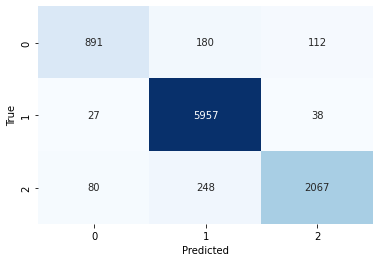

In [ ]:
#Bagging Classifier
bag = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', BaggingClassifier())])
bag.fit(x_train, y_train)

label=['negative', 'neutral','positive']
y_pred = bag.predict(x_test)
acc_bag = accuracy_score(y_pred, y_test)*100
print("accuracy =", acc_bag)
cm_bag = confusion_matrix(y_test, y_pred)
print("Confusion matrix \n", cm_bag)
clfr = metrics.classification_report(y_test, y_pred, target_names=label)
print("Classification Report: Bagging Classifier with text \n", clfr) 

label=['negative', 'neutral','positive']
sns.heatmap(cm_bag, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
bag.fit(xs_train, y_train)
label=['negative', 'neutral','positive']
y_pred = bag.predict(xs_test)
acc_bags = accuracy_score(y_pred, y_test)*100
print("accuracy =", acc_bags)
cm_bags = confusion_matrix(y_test, y_pred)
print("Confusion matrix \n", cm_bags)
clfr = metrics.classification_report(y_test, y_pred, target_names=label)
print("Classification Report: \n", clfr) 

accuracy = 92.51041666666666
Confusion matrix 
 [[ 909  165  109]
 [  30 5905   87]
 [  82  246 2067]]
Classification Report: 
               precision    recall  f1-score   support

    negative       0.89      0.77      0.82      1183
     neutral       0.93      0.98      0.96      6022
    positive       0.91      0.86      0.89      2395

    accuracy                           0.93      9600
   macro avg       0.91      0.87      0.89      9600
weighted avg       0.92      0.93      0.92      9600



accuracy = 92.09375
Confusion matrix 
 [[ 883  188  112]
 [  38 5919   65]
 [  80  276 2039]]
Classification Report: Bagging Classifier with text_lemmatized
               precision    recall  f1-score   support

    negative       0.88      0.75      0.81      1183
     neutral       0.93      0.98      0.95      6022
    positive       0.92      0.85      0.88      2395

    accuracy                           0.92      9600
   macro avg       0.91      0.86      0.88      9600
weighted avg       0.92      0.92      0.92      9600



Text(33.0, 0.5, 'True')

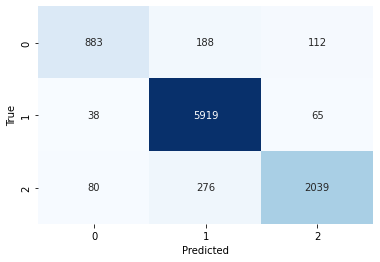

In [ ]:
bag.fit(xl_train, y_train)
label=['negative', 'neutral','positive']
y_pred = bag.predict(xl_test)
acc_bagl = accuracy_score(y_pred, y_test)*100
print("accuracy =", acc_bagl)
cm_bagl = confusion_matrix(y_test, y_pred)
print("Confusion matrix \n", cm_bagl)
clfr = metrics.classification_report(y_test, y_pred, target_names=label)
print("Classification Report: Bagging Classifier with text_lemmatized\n", clfr) 

label=['negative', 'neutral','positive']
sns.heatmap(cm_bagl, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')

## 6.7 Decision Tree

accuracy = 92.3125
Confusion matrix 
 [[ 916  149  118]
 [  65 5878   79]
 [ 130  197 2068]]
Classification Report: 
               precision    recall  f1-score   support

    negative       0.82      0.77      0.80      1183
     neutral       0.94      0.98      0.96      6022
    positive       0.91      0.86      0.89      2395

    accuracy                           0.92      9600
   macro avg       0.89      0.87      0.88      9600
weighted avg       0.92      0.92      0.92      9600



Text(33.0, 0.5, 'True')

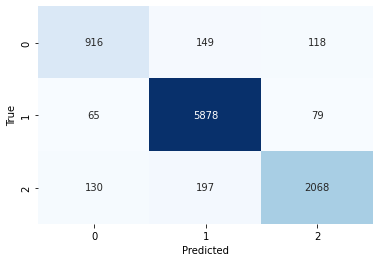

In [ ]:
#Decision Trees
dt = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', DecisionTreeClassifier())])
dt.fit(x_train, y_train)

label=['negative', 'neutral','positive']
y_pred = dt.predict(x_test)
acc_dt = accuracy_score(y_pred, y_test)*100
print("accuracy =", acc_dt)
cm_dt = confusion_matrix(y_test, y_pred)
print("Confusion matrix \n", cm_dt)


label=['negative', 'neutral','positive']
clfr = metrics.classification_report(y_test, y_pred, target_names=label)
print("Classification Report: \n", clfr) 
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
dt.fit(xs_train, y_train)
label=['negative', 'neutral','positive']
y_pred = dt.predict(xs_test)
acc_dts = accuracy_score(y_pred, y_test)*100
print("accuracy =", acc_dts)
cm_dts = confusion_matrix(y_test, y_pred)
print("Confusion matrix \n", cm_dts)
clfr = metrics.classification_report(y_test, y_pred, target_names=label)
print("Classification Report: \n", clfr) 

accuracy = 91.95833333333333
Confusion matrix 
 [[ 934  127  122]
 [  88 5796  138]
 [ 115  182 2098]]
Classification Report: 
               precision    recall  f1-score   support

    negative       0.82      0.79      0.81      1183
     neutral       0.95      0.96      0.96      6022
    positive       0.89      0.88      0.88      2395

    accuracy                           0.92      9600
   macro avg       0.89      0.88      0.88      9600
weighted avg       0.92      0.92      0.92      9600



In [ ]:
dt.fit(xl_train, y_train)
label=['negative', 'neutral','positive']
y_pred = dt.predict(xl_test)
acc_dtl = accuracy_score(y_pred, y_test)*100
print("accuracy =", acc_dtl)
cm_dtl = confusion_matrix(y_test, y_pred)
print("Confusion matrix \n", cm_dtl)
clfr = metrics.classification_report(y_test, y_pred, target_names=label)
print("Classification Report: \n", clfr) 

accuracy = 91.46875
Confusion matrix 
 [[ 914  148  121]
 [  82 5818  122]
 [ 121  225 2049]]
Classification Report: 
               precision    recall  f1-score   support

    negative       0.82      0.77      0.79      1183
     neutral       0.94      0.97      0.95      6022
    positive       0.89      0.86      0.87      2395

    accuracy                           0.91      9600
   macro avg       0.88      0.86      0.87      9600
weighted avg       0.91      0.91      0.91      9600



# 7. Conclusion

In [ ]:
data = {'Classifiers': ['Multinomial NB', 'Logistic Regression', 'SGD Classifier', 'Random Forest Classifier', 
                        'Decision Tree Classifier', "Bagging Classifier"],
        'Accuracy': [acc_nb, acc_lr, acc_sgd, acc_rfc, acc_dt, acc_bag],
        "Accuracy_Stemmed":[acc_nbs,acc_lrs, acc_sgds, acc_rfcs,acc_dts, acc_bags],
        "Accuracy_Lemmatized":[acc_nbl,acc_lrl, acc_sgdl, acc_rfcl, acc_dtl,acc_bagl]}
Accuracies = pd.DataFrame(data=data)
Accuracies.set_index('Classifiers', inplace=True)
Accuracies

,Accuracy,Accuracy_Stemmed,Accuracy_Lemmatized
Classifiers,,,
Multinomial NB,82.729167,80.895833,82.062500
Logistic Regression,92.770833,91.885417,92.416667
SGD Classifier,93.291667,92.395833,92.843750
Random Forest Classifier,92.333333,91.885417,91.989583
Decision Tree Classifier,92.312500,91.958333,91.468750
Bagging Classifier,92.864583,92.510417,92.093750
